In [10]:
import torch, torchvision
from torch.utils.cpp_extension import CUDA_HOME; 

#check versions and CUDA
print(torch.__version__)
!gcc --version
print(torch.version.cuda)
print(torch.cuda.is_available(), CUDA_HOME)

1.5.0+cu101
gcc (GCC) 4.8.5 20150623 (Red Hat 4.8.5-36)
Copyright (C) 2015 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.

10.1
True /usr/local/cuda


In [11]:
#%load_ext autoreload
#%autoreload 2

# import common libraries
import numpy as np
import cv2
import os
import random
import matplotlib.pylab as plt
from PIL import Image
from tqdm import tqdm
import timeit

# import some detectron2 utilities
import detectron2
print(detectron2.__version__)
import sys
sys.path.append('../')

from Nucleus import ImageInput
from Nucleus import ImageTile
from Nucleus import Stitcher
from detectron2_predict import detectron_predict
from detectron2_predict import detectron_init


0.1.2


# Input data

Input image shape: (1024, 1024, 3)
Minimum pixel value: 0
Maximum pixel value: 255


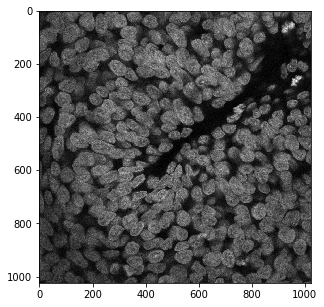

In [12]:
ROOT_PATH = "../test/"
IMG_PATH = "img/"
MASKS_PATH = "masks/"

# images should be divisible by 256 or 128 e.g. 1024x1024 or 2084x512

# test image
input_img = "img_z164.tif"


img = Image.open(ROOT_PATH+IMG_PATH+input_img)
img_ch = []
for i in range(img.n_frames):
    img.seek(i)
    img_ch.append(np.array(img))
img = np.array(img_ch)
sz=img[0]

one = ImageInput(img_str=sz, step=256)
one.show_me()

Using step of 256px.
Splitting image in main tiles...
Splitting image in vertical border tiles...
Splitting image in horizontal border tiles...
Predicting...
Main_tiles
V_tiles
H_tiles
The time was 9.10 sec
 This image tile goes from 128 to  640 width (x) and from 640 to 896 height (y). The step is 256.


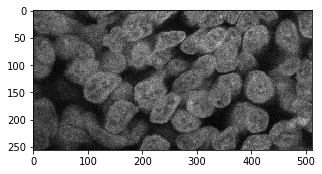

In [13]:
# split image in main tiles 
#main_tiles = one.make_tiles('simple')
#main_tiles[10].show_me()

# split image in tiles for 'stitch_v1' 
m_tiles, v_tiles, h_tiles = one.make_tiles('stitch_v1')

#just shows an example
h_tiles[9].show_me()


# Predict

In [8]:
# For 'no_stitching'
#tic=timeit.default_timer()
#m_out = [detectron_predict(_im) for _im in m_tiles]
#toc=timeit.default_timer()
#print(f'The time was {toc - tic}')

# For 'stitch_v1'

print("Predicting...")
pred= detectron_init(model='invitro') # or 'SC_sections'



tic=timeit.default_timer()
print("Main_tiles")
m_out = [detectron_predict(_im,pred) for _im in m_tiles] 
print("V_tiles")
v_out = [detectron_predict(_im,pred) for _im in v_tiles]
print("H_tiles")
h_out = [detectron_predict(_im,pred) for _im in h_tiles]
toc=timeit.default_timer()
print('The time was {:.2f} sec'.format(toc - tic))

TypeError: detectron_predict() got an unexpected keyword argument 'model'

# Stitch instances

The time was 7.65 sec
This image has 438 segmented nuclei.


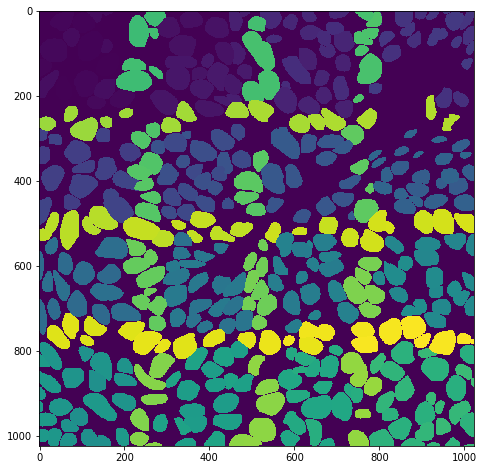

In [14]:
# just main tiles, no stitching
# test = Stitcher(one)
# seg_mask, nuclei_tally = test.no_stitch([m_tiles] , [m_out])

# plt.figure(figsize=(8,8))
# plt.imshow(seg_mask)
# print(nuclei_tally)


# current only available stitchin method
tic=timeit.default_timer()
test = Stitcher(one)
seg_mask, nuclei_tally = test.stitch_v1([m_tiles,v_tiles,h_tiles] , [m_out, v_out, h_out], margin=5)
toc=timeit.default_timer()
print('The time was {:.2f} sec'.format(toc - tic))


plt.figure(figsize=(8,8))
plt.imshow(seg_mask)
print(f'This image has {nuclei_tally} segmented nuclei.')

# Saving segmentation

In [12]:
# save mask 
im = Image.fromarray(seg_mask)
im.save(ROOT_PATH+MASKS_PATH+input_img)


# save to COCO
from utils import PNG_to_JSON
PNG_to_JSON.coco_output(ROOT_DIR=ROOT_PATH,
                        image_files=[input_img],
                        output='../outputs/test_out1_stitch_v1.json') 


  2%|▏         | 8/438 [00:00<00:05, 72.57it/s]

utils.PNG_to_JSON


100%|██████████| 438/438 [00:06<00:00, 64.38it/s]

Done!


loading annotations into memory...
Done (t=0.13s)
creating index...
index created!
COCO categories: 
nucleus



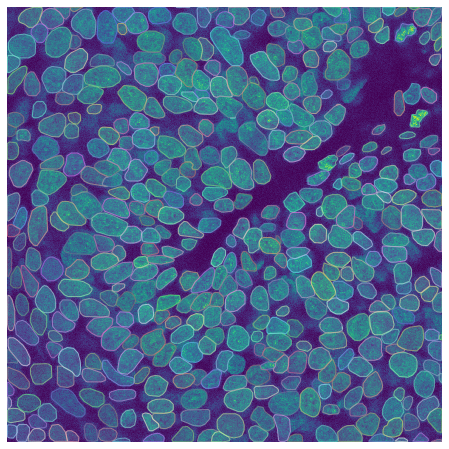

In [15]:
# save overlay segmentation and image
from Nucleus import coco_nucleus
from skimage import io


segmFile ='../outputs/test_out1_stitch_v1.json'
imgDir   = ROOT_PATH+IMG_PATH
output_imageFile = '../outputs/test_out1_stitch_v1.png'
pick_image_number=0


coco=coco_nucleus(segmFile)
cats = coco.loadCats(coco.getCatIds())
nms=[cat['name'] for cat in cats]
print('COCO categories: \n{}\n'.format(' '.join(nms)))
catIds = coco.getCatIds(catNms=['nucleus']);
imgIds = coco.getImgIds(catIds=catIds);
img = coco.loadImgs(imgIds[pick_image_number])[0]


plt.figure(figsize=(8,8))
I = io.imread(imgDir+img['file_name'])
plt.imshow(I); plt.axis('off')
annIds = coco.getAnnIds(imgIds=img['id'], catIds=catIds)
anns = coco.loadAnns(annIds)
coco.showAnns_Nucleus(anns)
#plt.savefig(output_imageFile,dpi=300,bbox_inches='tight',pad_inches=0)